## First attempts at analyzing modulated spectra 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# For "interactive" plots:
#%matplotlib notebook
# For regular plots:
%matplotlib inline
# For bigger inline plots (size in "inches")
plt.rcParams['figure.figsize'] = [8, 6]

## Defining signal and carrier
In the next cell, the signal (of interest) and carrier signal are defined.

Also AM modulation of the two and superposition functions are defined.

Lastly a time array with a very generous sampling frequency is chosen.

In [140]:
### BEP 

#Signal properties, low amplitude

f_sig = 100e9           #frequency [Hz]
w_sig = 2*np.pi*f_sig   #angular frequency [rad/s]
A_sig = 0.1             #amplitude in [V]


def signal(t): 
    signal = A_sig*np.sin(w_sig*t)
    return signal

#Carrier properties, high amlitude

f_car = 200e9           #frequency [Hz]
w_car = 2*np.pi*f_car   #angular frequency [rad/s]
A_car = 1               #amplitude in [V]
phi0 = 0                #carrier phase

def carrier(t,phi0):
    carrier = A_car*np.sin(w_car*t - phi0)
    return carrier

#Carrier AM modulated by signal
def AM(t,phi0):
    comb = (1+signal(t))*carrier(t,phi0)
    return comb
    
#simple superposition  

def SUP(t,phi0):
    comb = signal(t) + carrier(t,phi0)
    return comb

#superposition filtering

def SUP_f(t,phi0,phi1):
    filt = SUP(t,phi0) + carrier(t,phi1)
    return filt
    

#Choose sampling frequency 50*f so Nyquist lim is ok
N = 100 #number of samples per oscillation
f_sampling = np.maximum(f_sig,f_car)*N

#t = np.arange(t0,tf,1/f_sampling)
#print(t)


#make sampling time array
t0 = 0
tf = 1e-10
T = 1/f_car
N_osc = int(tf/T)  #Number of oscillations in the time trace
t = np.linspace(t0,tf,N_osc*N, endpoint = False)



## Powerspectra

In this next section I analyze the power spectra of the carrier and then the AM modulation and Superposition. 

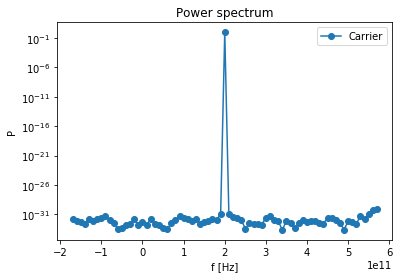

In [141]:
#function for plotting powerspectra around the carrier frequency
#enter label a as 'dsfsbfkh'
def plot_power_spectrum(t,v,a):
    
    vt = np.fft.fft(v)

    # For plotting, let's shift them
    vts = np.fft.fftshift(vt)
    fs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]))
    
    # Calculate power spectrum and normalise it
    power = np.abs(vts)**2
    power /= max(power)
    
    span = 0.75e12
    n1 = np.where(fs >= f_car-span/2)[0][0]
    n2 = np.where(fs >= f_car+span/2)[0][0]
    
    plt.plot(fs[n1:n2],power[n1:n2],"o-", label = a)
    plt.yscale('log')
    plt.legend()
    plt.title('Power spectrum')
    plt.xlabel('f [Hz]')
    plt.ylabel('P')
    
plot_power_spectrum(t,carrier(t,phi0),'Carrier')

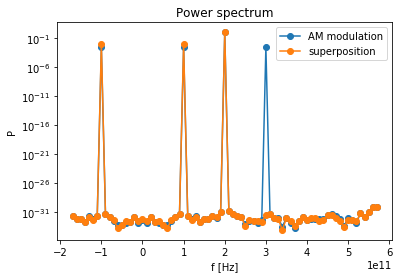

In [142]:
##Analyzing Fourier spectra

#AM signal
AM_sig = AM(t,phi0)

#superposition signal
SUP_sig = SUP(t,phi0)

plot_power_spectrum(t,AM_sig, 'AM modulation')
plot_power_spectrum(t,SUP_sig, 'superposition')

## Simple carrier substraction

Here I make a very straight-forward attempt at filtering out our signal by adding a delayed carrier to the superposition. Analogous to a noiseless Michelson interferometer.

In [143]:
#Filter superposition 

def update(phi1 = np.pi):
    plt.plot(t,signal(t), label = 'signal')
    plt.plot(t,SUP_f(t,phi0,phi1), label = 'filtered')
    plt.xlabel('t [s]')
    plt.ylabel('Amplitude [V]')
    plt.legend()
    
interact(update, phi1 = (np.pi/2,3*np.pi/2,100))

interactive(children=(FloatSlider(value=3.141592653589793, description='phi1', max=4.71238898038469, min=1.570…

<function __main__.update(phi1=3.141592653589793)>

## Implementing Noise

In this next section I attempt to create some amplitude noise to add to my carrier.

In [191]:
##Creating some amplitude noise in the carrier 
#First attempt: random normal noise with LPF

#random noise
amp = np.random.normal(loc = 0, scale = 0.2, size = len(t))      #random normal noise for every t [V]

#fft noise
amp_t = np.fft.fft(amp)
f = np.fft.fftfreq(len(t), d=t[1])

#LPF cutoff f0
f0 = 40e9                #cutoff freq f0 [Hz]
lpf = 1/((1j*f/f0)+1)    #response lpf

#filtered amplitude
amp_t_f = amp_t*lpf
amp_f = np.real(np.fft.ifft(amp_t_f))

Text(0.5,1,'Amplitude noise vs time')

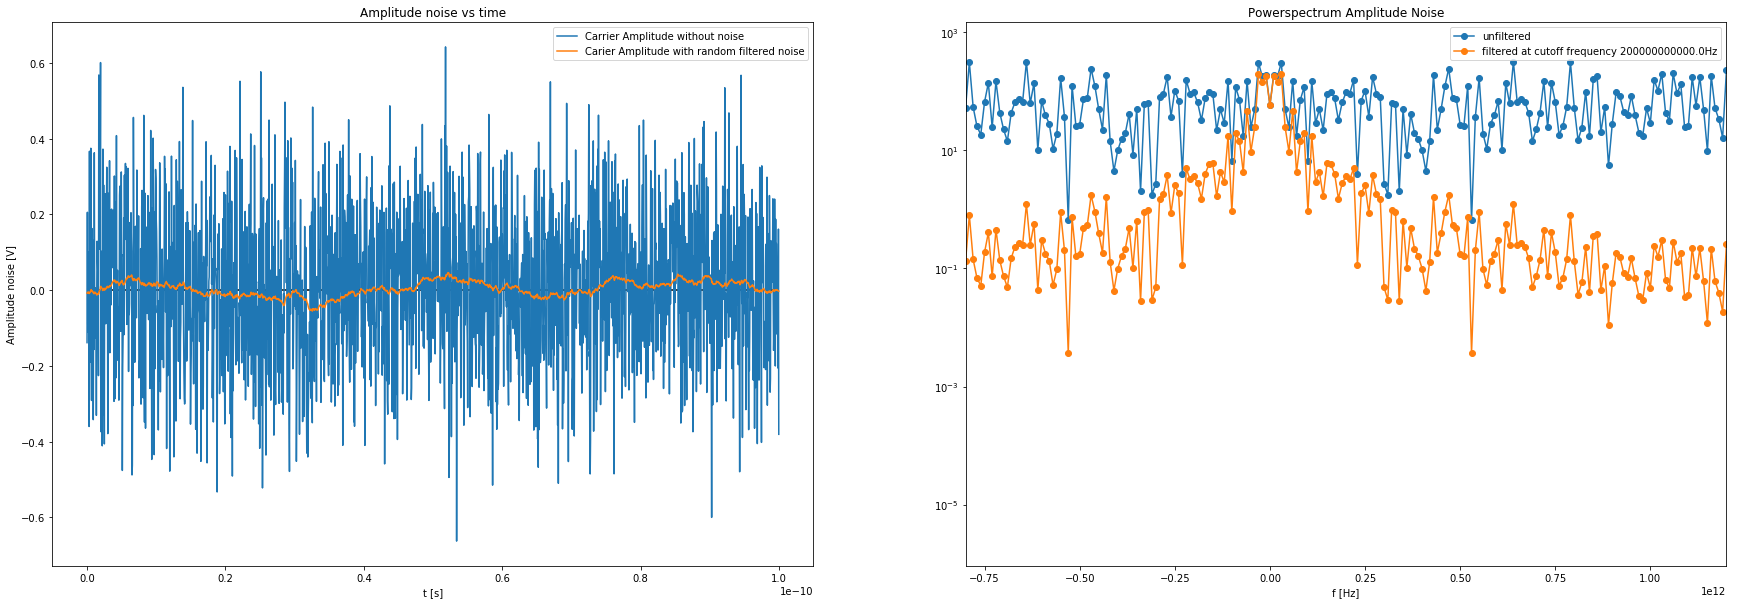

In [192]:
# For plotting the amplitude noise, let's shift them

amp_ts = np.fft.fftshift(amp_t)
amp_t_fs = np.fft.fftshift(amp_t_f)
fs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]))
plt.figure(figsize=(30,10))

plt.subplot(122)
plt.semilogy(fs,np.abs(amp_ts)**2, "o-", label = 'unfiltered')
plt.semilogy(fs,np.abs(amp_t_fs)**2,"o-", label = 'filtered at cutoff frequency ' + str(f_car) + 'Hz')
plt.xlim(f_car - 1e12,f_car + 1e12)
plt.xlabel('f [Hz]')
plt.legend()
plt.title('Powerspectrum Amplitude Noise')

plt.subplot(121)
plt.plot(t,amp, label = 'Carrier Amplitude without noise')
plt.plot(t,amp_f, label = 'Carier Amplitude with random filtered noise')
plt.hlines(0,t[0],t[-1])
plt.xlabel('t [s]')
plt.ylabel('Amplitude noise [V]')
#plt.ylim(0,max(amp)*1.1)
plt.legend()
plt.title('Amplitude noise vs time')


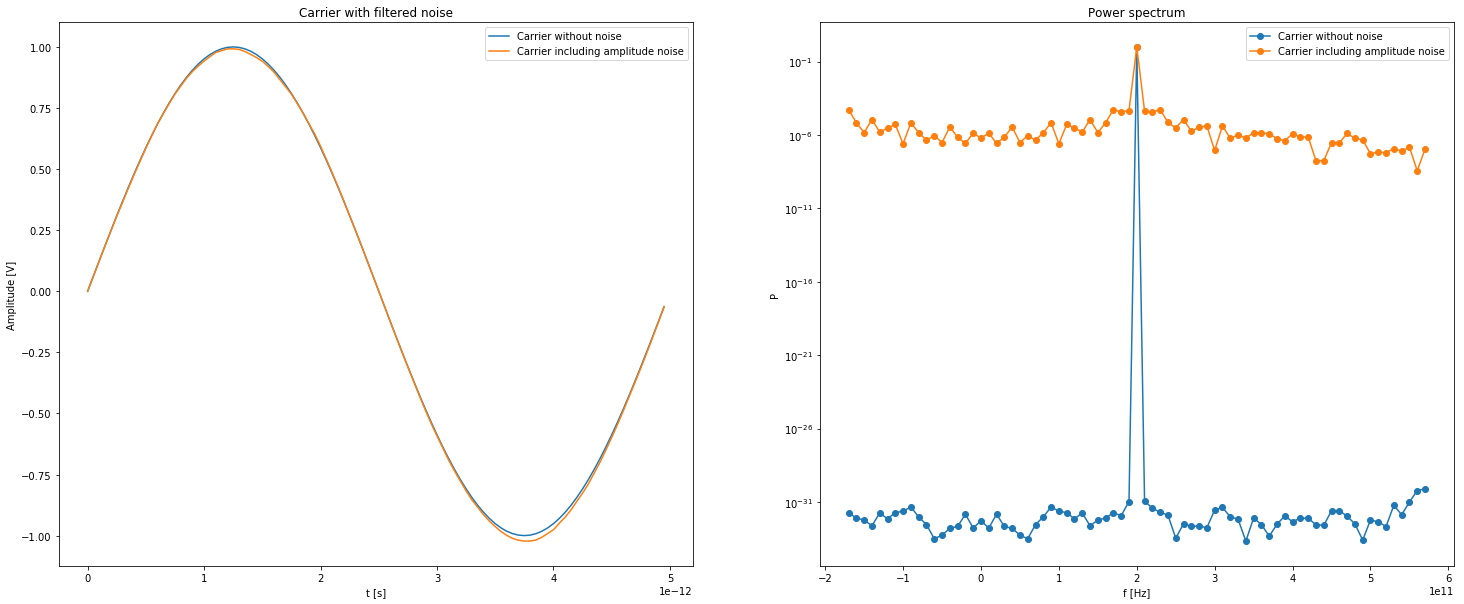

In [193]:
##Now adding the lpf noise to the carrier

def new_car(t,phi0):
    return (amp_f+1)*carrier(t,phi0)

##Plotting the resulting carrier and powerspectra
plt.figure(figsize=(25,10))

plt.subplot(121)
plt.plot(t[0:100],carrier(t,phi0)[0:100], label = 'Carrier without noise')
plt.plot(t[0:100],new_car(t,phi0)[0:100], label = 'Carrier including amplitude noise')
plt.xlabel('t [s]')
plt.ylabel('Amplitude [V]')
plt.title('Carrier with filtered noise')
plt.legend()
#plt.xlim(4e-13,8e-13)

plt.subplot(122)
plot_power_spectrum(t,carrier(t,phi0), 'Carrier without noise')
plot_power_spectrum(t,new_car(t,phi0), 'Carrier including amplitude noise')

Alright something is not working out... 

## New attempt
The previous filter is an lpf with a cut-off far below the carrier frequency. So it is not strange that we don't see the filter reflected in the powerspectrum. We are interested mostly in Amplitude noise of a frequency close to the carrier frequency. So in this next part I will attempt to take a band pass filter and filter the amplitude noise around the carrier frequency.

Text(0.5,1,'Amplitude noise vs time')

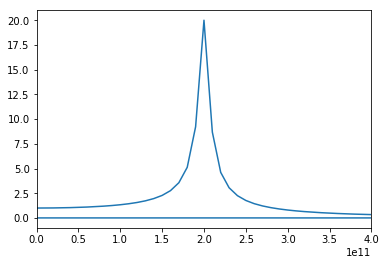

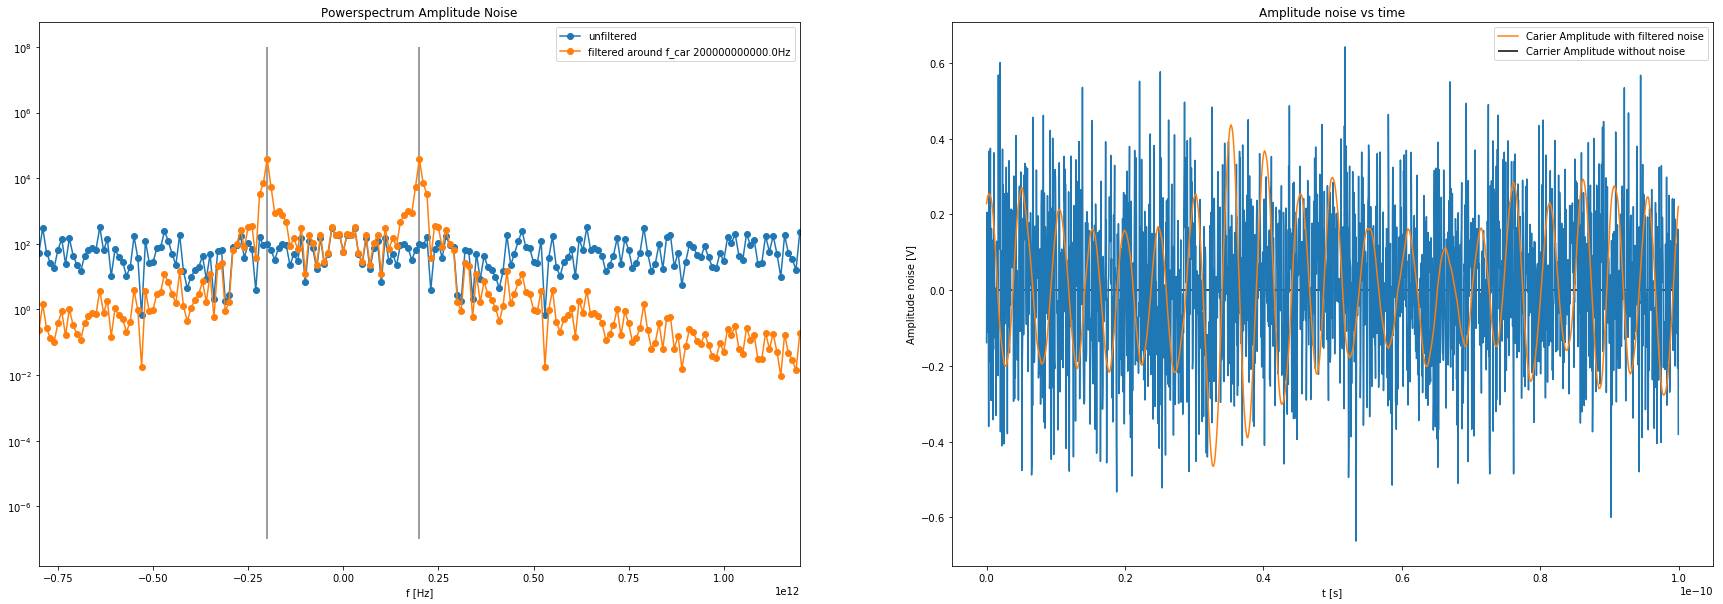

In [194]:
## Garys HO filter

#filter around f_car
f02 = f_car

#quality factor
Q = 20

#impuls response of HO
H = f02**2 / (f02**2 - f**2 + 1j*f*f02/Q)

plt.plot(f,np.abs(H))
plt.xlim(0,400e9)

#filter amplitude
amp_tf2 = H*amp_t
amp_f2 = np.real(np.fft.ifft(amp_tf2))

# For plotting, let's shift them
amp_ts = np.fft.fftshift(amp_t)
amp_tf2s = np.fft.fftshift(amp_tf2)
fs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]))
plt.figure(figsize=(30,10))

plt.subplot(121)
plt.vlines((-f_car,f_car),10e-8,10e7, '0.5')
plt.semilogy(fs,np.abs(amp_ts)**2, "o-", label = 'unfiltered')
plt.semilogy(fs,np.abs(amp_tf2s)**2,"o-", label = 'filtered around f_car ' + str(f_car) + 'Hz')
plt.xlim(f_car - 1e12,f_car + 1e12)
plt.xlabel('f [Hz]')
plt.legend()
plt.title('Powerspectrum Amplitude Noise')

plt.subplot(122)
plt.plot(t,amp)
plt.plot(t,amp_f2, label = 'Carier Amplitude with filtered noise')
plt.hlines(0,t[0],t[-1], label = 'Carrier Amplitude without noise')
plt.xlabel('t [s]')
plt.ylabel('Amplitude noise [V]')
plt.legend()
plt.title('Amplitude noise vs time')


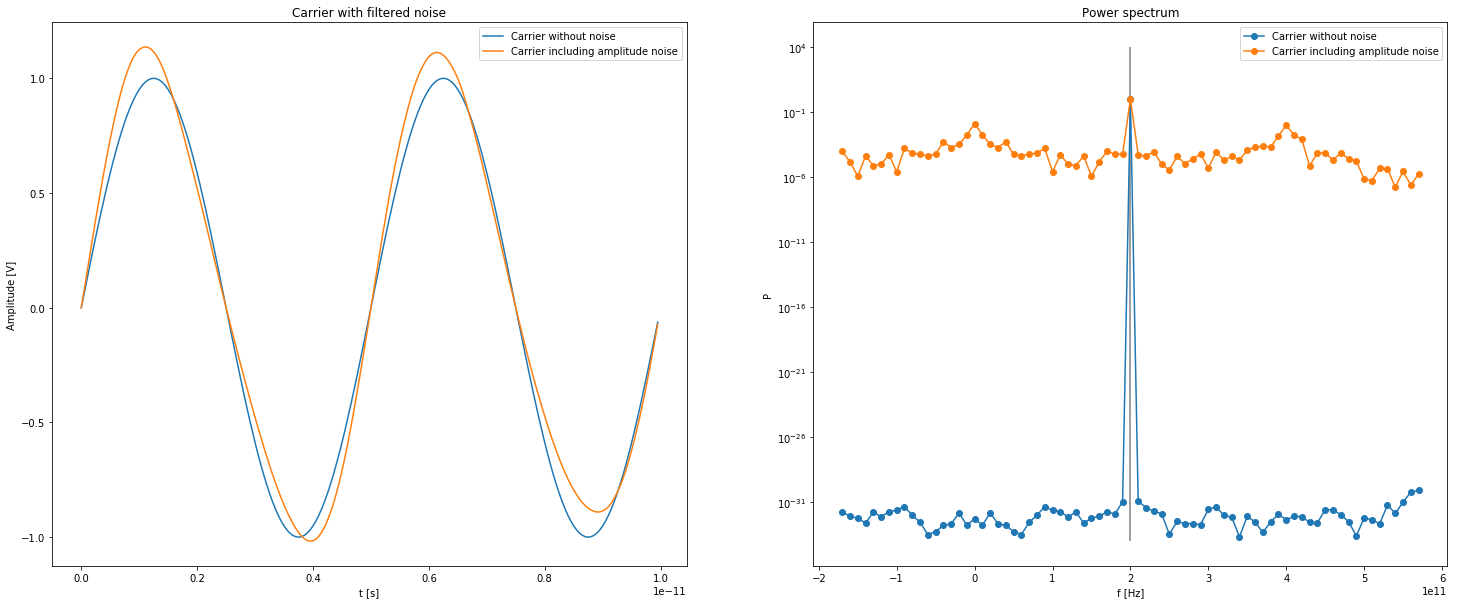

In [195]:
def new_car2(t,phi0):
    y = (amp_f2+1)*carrier(t,phi0)
    return y

plt.figure(figsize=(25,10))

plt.subplot(121)
plt.plot(t[0:200],carrier(t,phi0)[0:200], label = 'Carrier without noise')
plt.plot(t[0:200],new_car2(t,phi0)[0:200], label = 'Carrier including amplitude noise')
plt.xlabel('t [s]')
plt.ylabel('Amplitude [V]')
plt.title('Carrier with filtered noise')
plt.legend()
#plt.xlim(4e-13,8e-13)

plt.subplot(122)
plot_power_spectrum(t,carrier(t,phi0), 'Carrier without noise')
plot_power_spectrum(t,new_car2(t,phi0), 'Carrier including amplitude noise')
plt.vlines((f_car),10e-35,10e3, '0.5')

## Yet another attempt using a scipy butterworth filter

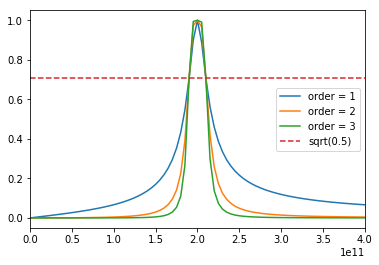

In [196]:
# Lets try this scipy package

## Now trying a butterworth band pass filter
from scipy.signal import butter, lfilter, freqz

B = 20e9                 #Bandwidth [Hz]
fl = f_car - B/2         #lower freq [Hz]
fu = f_car + B/2         #higher freq [Hz]

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#make a plot
for order in [1, 2, 3]:
    b, a = butter_bandpass(fl, fu, f_sampling, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((f_sampling * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    
plt.plot([0, 0.5 * f_sampling], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
plt.xlim(0,400e9)
plt.legend()

Text(0.5,1,'Amplitude noise vs time')

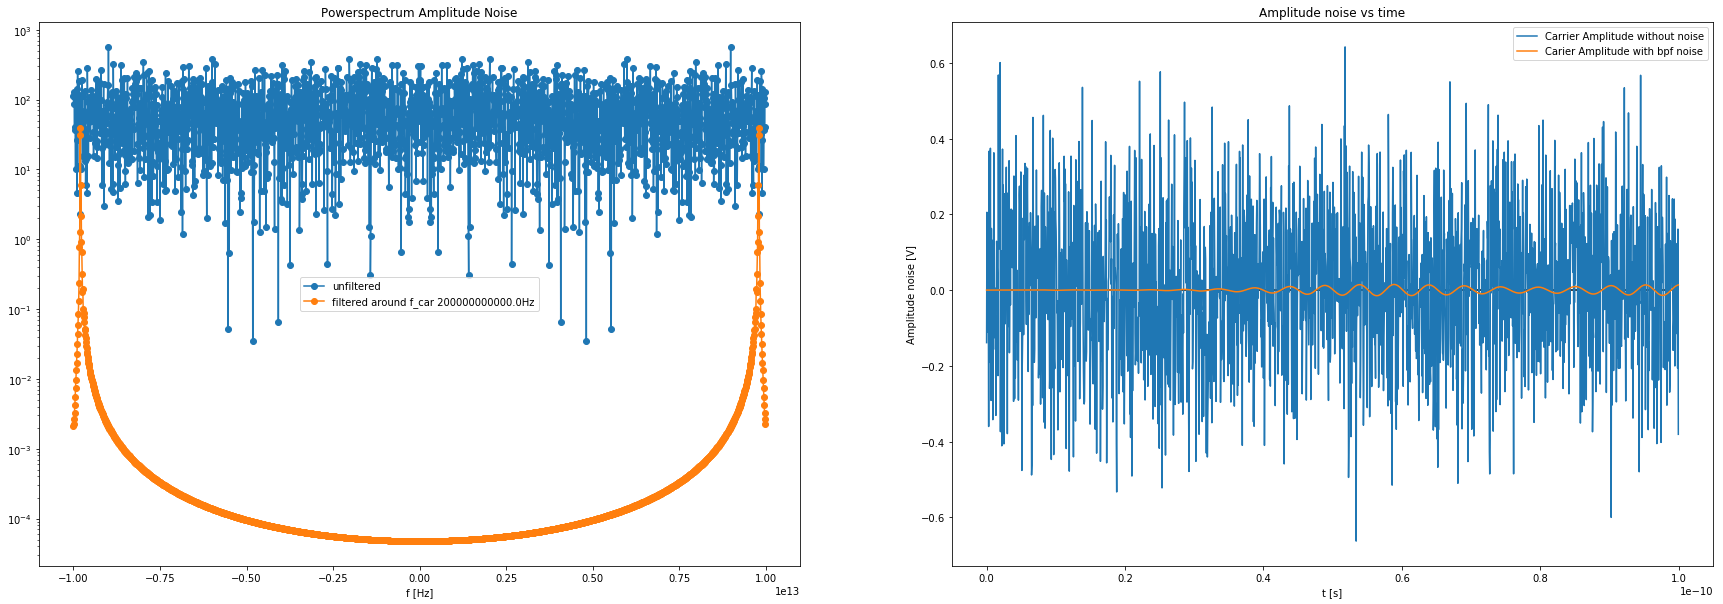

In [197]:
## Now trying to apply it

amp_bpf = butter_bandpass_filter(amp, fl, fu, f_sampling, order = 3)

amp_bpft = np.fft.fft(amp_bpf)

# For plotting, let's shift them
amp_ts = np.fft.fftshift(amp_t) #this one is weird

fs = np.fft.fftshift(np.fft.fftfreq(len(t), d=t[1]))
plt.figure(figsize=(30,10))

plt.subplot(121)
#plt.vlines((-f_car,f_car),10e-8,10e7, '0.5')
plt.semilogy(fs,np.abs(amp_ts)**2, "o-", label = 'unfiltered')
plt.semilogy(fs,np.abs(amp_bpft)**2,"o-", label = 'filtered around f_car ' + str(f_car) + 'Hz')
#plt.xlim(f_car - 1e12,f_car + 1e12)
plt.xlabel('f [Hz]')
plt.legend()
plt.title('Powerspectrum Amplitude Noise')

plt.subplot(122)
plt.plot(t,amp, label = 'Carrier Amplitude without noise')
plt.plot(t,amp_bpf, label = 'Carier Amplitude with bpf noise')
plt.hlines(0,t[0],t[-1])
plt.xlabel('t [s]')
plt.ylabel('Amplitude noise [V]')
plt.legend()
plt.title('Amplitude noise vs time')

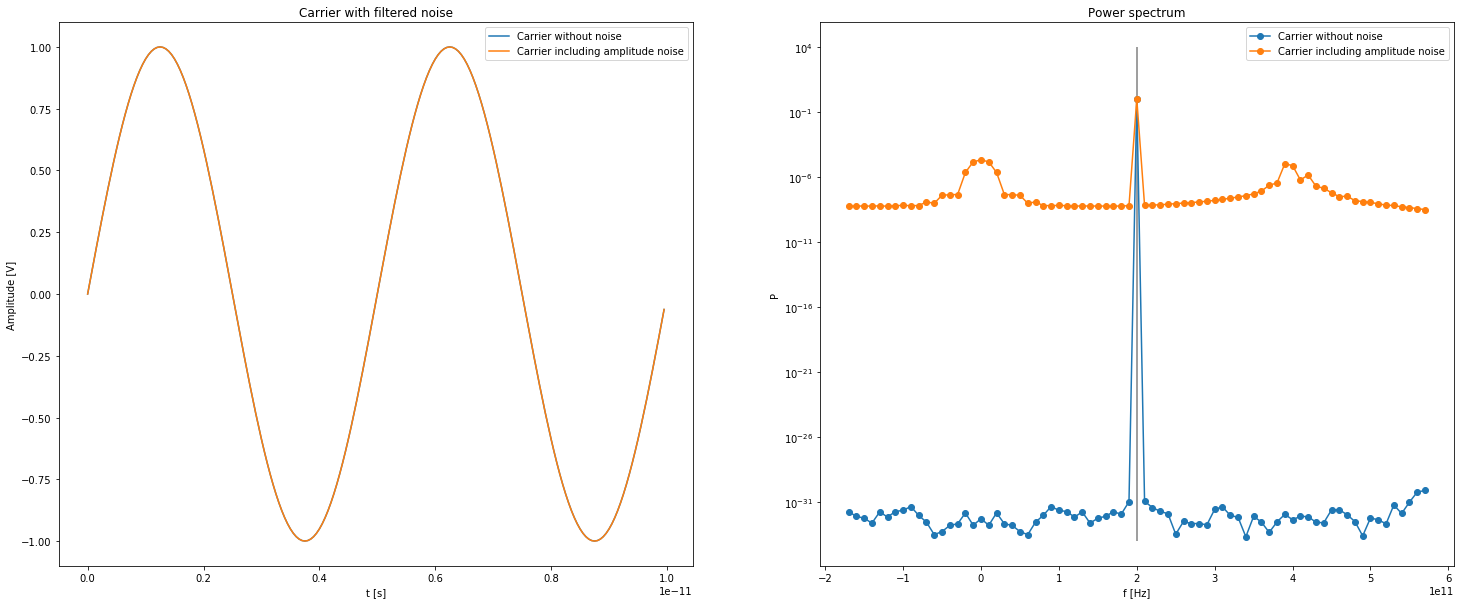

In [198]:
def new_car3(t,phi0):
    y = (amp_bpf+1)*carrier(t,phi0)
    return y

plt.figure(figsize=(25,10))

plt.subplot(121)
plt.plot(t[0:200],carrier(t,phi0)[0:200], label = 'Carrier without noise')
plt.plot(t[0:200],new_car3(t,phi0)[0:200], label = 'Carrier including amplitude noise')
plt.xlabel('t [s]')
plt.ylabel('Amplitude [V]')
plt.title('Carrier with filtered noise')
plt.legend()

plt.subplot(122)
plot_power_spectrum(t,carrier(t,phi0), 'Carrier without noise')
plot_power_spectrum(t,new_car3(t,phi0), 'Carrier including amplitude noise')
plt.vlines((f_car),10e-35,10e3, '0.5')

In [ ]:
#attempting BPF, not working yet
B = 10e6                  #Bandwidth [Hz]
fl = f_car - B/2
fu = f_car + B/2
f03 = f_car                #cutoff freq f0 [Hz]
#lpf = 1/((1j*f/fu)+1)    #LPF (f defined above)
hpf = 1/(1-(1j*fl/f))    #HPF